<a href="https://colab.research.google.com/github/csralvall/online_game_toxicity/blob/main/clustering_bow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import utility functions

In [1]:
from IPython.display import clear_output

### Install dependencies

In [2]:
!pip install -U kaggle pip setuptools wheel pandas sklearn numpy wget mr4mp
clear_output()

### Import libraries

In [3]:
from google.colab import drive, files
import pandas as pd
import spacy
import numpy as np
import pickle
import mr4mp
import sklearn.manifold
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from timeit import default_timer
from collections import Counter

### Setup dataframe print options

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Mount storage

In [5]:
# mount google drive unit to save computationally expensive results
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get subset of whole dataset

In [6]:
# english chats from original dataset with anotations
eng_annotated = '/content/drive/MyDrive/nlp/dota2_chat_eng_annotated_2.csv'
df_test = pd.read_csv(eng_annotated)[:10000].dropna().reset_index(drop=True)

### Get bad word list from memory

In [7]:
# get downloaded bad word list
word_list = "/content/drive/MyDrive/nlp/bad_words.txt"
# use set for fast queries
bad_words = set(line.strip() for line in open(word_list, 'r'))
# add new bad words
bad_words.update(['noob', 'noobs', 'stfu', 'fukign', 'fuking', 'fukin', 'nooob'])
bad_dict = dict.fromkeys(bad_words, 0)

### Create Bag of Words (BOW)

In [8]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [9]:
# function to transform chats in sets of words
def chat_to_set(chat: [str]) -> {str}:
    return set(chat.split())

# function to join all chat sets in one big set
def join_chat_sets(chat: {str},bag: {str}) -> {str}:
    return bag.union(chat)

In [10]:
# from cleaned english chats get all of them without nan values
chats = df_test[['tokens']].dropna().astype(str).values

In [11]:
chats = flatten(chats)

In [12]:
# use map reduce model to create the Bag of Words (BOW)
start = default_timer()
pool = mr4mp.pool(10) # roughly 1hs with gpu with full eng dataset
set_of_words = pool.mapreduce(chat_to_set, join_chat_sets, chats)
pool.close()
bag_of_words = dict.fromkeys(set_of_words, 0)
print("Finished in " + str(default_timer()-start) + "s using " + str(len(pool)) + " process(es).")

Finished in 0.5121319269999276s using 10 process(es).


In [13]:
# save bag of words in drive (very expensive to compute)
# use when running code with full dataset
with open('/content/drive/MyDrive/nlp/bag_of_words.pkl', 'wb') as dict_file:
    pickle.dump(bag_of_words, dict_file)
    dict_file.close()

#### Clustering utils

In [14]:
def get_bad_vec(lexicon, chat_words):
    for word in chat_words:
        if word in lexicon:
            lexicon[word] += 1

    bad_vec = np.fromiter(lexicon.values(), dtype=int)
    
    return bad_vec

In [15]:
def get_bow_vec(bow, chat_words):
    for word in chat_words:
        if word in bow:
            bow[word] += 1

    bow_vec = np.fromiter(bow.values(), dtype=int)

    return bow_vec

In [16]:
intensity = df_test[['intensity']].copy()

### Create bow vectors for clustering

In [17]:
for idx, chat in enumerate(chats):
    bow = dict.fromkeys(bag_of_words, 0)
    lexicon = dict.fromkeys(bad_words, 0)
    chat_intensity = intensity.loc[idx]
    chat_words = chat.split()
    bad_vec = get_bad_vec(lexicon, chat_words)
    bow_vec = get_bow_vec(bow, chat_words)
    bow_bad_int_vec = np.hstack((bow_vec, bad_vec, chat_intensity)).ravel()
    if idx == 0:
        bow_serie = bow_bad_int_vec
    else:
        bow_serie = np.concatenate((bow_serie, bow_bad_int_vec))


### Reshape data

In [19]:
bow_ncolumns = len(set_of_words) + len(bad_words) + 1
bow_serie = bow_serie.astype('float').reshape((-1, bow_ncolumns))
bow_matrix = bow_serie[~np.isnan(bow_serie)].reshape((-1, bow_ncolumns))

### Matrix reduction

In [29]:
def reduce_matrix(matrix: np.ndarray, *, variance_treshold: float):
    print(f'INPUT SHAPE: {matrix.shape}')
    # reduce all vectors to [0, 1] space
    normalized_matrix = normalize(matrix, axis=1)
    # compute variances in each row
    matrix_variances = np.var(matrix, axis=0)
    # create mask for features with high correlation (low variance)
    bool_mask = np.where(matrix_variances < variance_treshold)
    # filter features with high correlation (variance under treshold)
    raked_matrix = np.delete(normalized_matrix, bool_mask, axis=1)
    print(f'OUTPUT SHAPE: {raked_matrix.shape}')
    return raked_matrix

### Reduce matrix

In [30]:
bow_reduced = reduce_matrix(bow_matrix, variance_treshold=0.0001)

INPUT SHAPE: (10000, 7255)
OUTPUT SHAPE: (10000, 2239)


### Save matrix

In [31]:
with open('/content/drive/MyDrive/nlp/bow_serie_10000.npy', 'wb') as output_file:
    np.save(output_file, bow_matrix)

### Load matrix from storage

In [32]:
bow_reduced = np.load('/content/drive/MyDrive/nlp/bow_serie_10000.npy')

#### Clustering

In [33]:
def generate_clusters(
    matrix: np.ndarray,
    n_clusters: int
) -> KMeans:
    # generate word clusters using the KMeans algorithm.
    print("\nClustering started")
    # Instantiate KMeans clusterer for n_clusters
    km_model = KMeans(n_clusters=n_clusters, random_state=3)
    # create clusters
    km_model.fit(matrix)
    print("Clustering finished")
    return km_model

### Create clusters

In [39]:
bow_clusters = generate_clusters(bow_reduced, 50)


Clustering started
Clustering finished


### Cluster utility functions

In [40]:
def display_summary(clusters: KMeans):
    cluster_count = Counter(sorted(clusters.labels_))
    for cluster in cluster_count:
        print ("Cluster#", cluster," - Total words:", cluster_count[cluster])

In [41]:
def annotate_dataframe(clusters: KMeans, df: pd.DataFrame, col_name: str):
    cluster_count = Counter(sorted(clusters.labels_))
    #sort cluster centers by proximity to centroid
    order_centroids = clusters.cluster_centers_.argsort()[:, ::-1] 

    clusters_df = np.zeros(len(df))
    
    for cluster_idx in cluster_count:
        # get words inside each cluster
        cluster_words = np.where(clusters.labels_ == cluster_idx)[0]
        # anotate all chats in cluster
        for idx in cluster_words:
            clusters_df[idx] = int(cluster_idx)

    df[col_name] = clusters_df

### Show info about clusters

In [42]:
display_summary(bow_clusters)

Cluster# 0  - Total words: 21
Cluster# 1  - Total words: 73
Cluster# 2  - Total words: 5401
Cluster# 3  - Total words: 3
Cluster# 4  - Total words: 11
Cluster# 5  - Total words: 195
Cluster# 6  - Total words: 321
Cluster# 7  - Total words: 152
Cluster# 8  - Total words: 264
Cluster# 9  - Total words: 117
Cluster# 10  - Total words: 17
Cluster# 11  - Total words: 511
Cluster# 12  - Total words: 4
Cluster# 13  - Total words: 1
Cluster# 14  - Total words: 422
Cluster# 15  - Total words: 1
Cluster# 16  - Total words: 26
Cluster# 17  - Total words: 154
Cluster# 18  - Total words: 12
Cluster# 19  - Total words: 56
Cluster# 20  - Total words: 78
Cluster# 21  - Total words: 39
Cluster# 22  - Total words: 200
Cluster# 23  - Total words: 2
Cluster# 24  - Total words: 147
Cluster# 25  - Total words: 3
Cluster# 26  - Total words: 27
Cluster# 27  - Total words: 57
Cluster# 28  - Total words: 39
Cluster# 29  - Total words: 123
Cluster# 30  - Total words: 186
Cluster# 31  - Total words: 119
Cluster# 

In [43]:
df_test = df_test.copy()

### Annotate cluster for each row in dataframe

In [44]:
annotate_dataframe(bow_clusters, df_test, 'bow_clusters')

In [45]:
df_test['nwords'] = list(map(lambda x: len(x.split()), df_test['tokens']))

In [46]:
df_test.to_csv(f'/content/drive/MyDrive/nlp/bow_clusters_df.csv', index=False)

### Load Bag-of-Words clusters

In [47]:
df_test = pd.read_csv('/content/drive/MyDrive/nlp/bow_clusters_df.csv')

### Explore results

In [48]:
bow_group = df_test.groupby('bow_clusters')

Shilouette coeficient for this clustering

In [49]:
metrics.silhouette_score(bow_reduced, bow_clusters.labels_, metric='euclidean')

0.029093422209072118

#### Get toxicity score for each cluster

In [50]:
bow_score = (bow_group['toxicity'].sum() / bow_group['nwords'].sum())
bow_scored = pd.DataFrame({'score': bow_score.values, 'size': bow_group.size()})
bow_scored = bow_scored[bow_scored['score'] > 0.14]
bow_scored = bow_scored.sort_values(by=['score', 'size'], ascending=[False, False])
top_toxic_clusters = bow_scored.index.to_list()
bow_scored

,score,size
bow_clusters,,
32.0,0.545455,51
10.0,0.460000,17
38.0,0.455285,45
9.0,0.451104,117
22.0,0.444853,200
29.0,0.387013,123
30.0,0.379004,186
5.0,0.365177,195
12.0,0.315789,4


#### Explore clusters

In [51]:
bow_group.get_group(32)[['match','text']]

,match,text
377,183,you suck at dota
448,227,come suck my dick
1556,972,can you suck my dick?
1602,994,suck dazzle dick after game for boost?
1958,1216,u already suck kid
2166,1327,fucking monkey suck my dick
2293,1383,Sry clock but u suck :)
2319,1395,suck my big black dick
2322,1395,suck my big black cock
2470,1459,and u suck as an orgy


In [52]:
bow_group.get_group(10)[['match','text']]

,match,text
382,183,you dumb and blind?
385,183,"its pretty dumb you're complaining, you're lit..."
563,290,my lanes were dumb
970,537,that was dumb
976,539,real tired of ur dumb ass
1280,741,cause you guys so dumb cant win mmr
1382,839,sb dumb charge mid too
2292,1381,"talent, ignore this dumb rubick"
3961,2361,youre fucking dumb
3962,2361,you. are. fucking. dumb


In [53]:
bow_group.get_group(38)[['match','text']]

,match,text
148,83,stop pause idiot
740,389,i have now SB im not idiot anymore
841,445,nice mirana idiot
914,491,have idiot miranma
1014,554,fucking idiot offlaner
1037,565,crystals = skeleton farming idiot
1306,775,keep focus idiot
2404,1437,sorry my friend is an idiot :)
2556,1497,ok u are idiot too
2896,1711,you speak idiot?


In [54]:
bow_group.get_group(9)[['match','text']]

,match,text
83,43,that was more lucky than ur kill 😂:D
173,83,Dont kill the dog
205,107,make sure u can kill me 1st
279,129,but my teammates wont to kill u((9(
287,134,wow i got a kill while 2v1
303,150,techies go kill yourself
458,229,u lost 2 towers 2 kill me
503,257,how to win then no one can kill weaver and am
511,267,are you gonna suicide kill me
656,339,Cant believe a retard wanbts to kill instead o...


In [55]:
bow_group.get_group(22)[['match','text']]

,match,text
47,30,fuck off lol
54,32,yuou just fuck your ulti as hell
119,74,Fuck you for playing huskar
131,82,Ima out to fuck
161,83,Did you mother fuck a dog to born you
162,83,fuck dog to born ?
174,83,go fuck yourself xD bye bye dog
177,87,fuck the game
178,87,fuck this shit nap team
191,102,fuck this game


### Reduce dimensionality to display data

In [56]:
# use TSNE to reduce dimensionality of data
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(bow_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


### Display data without clusters

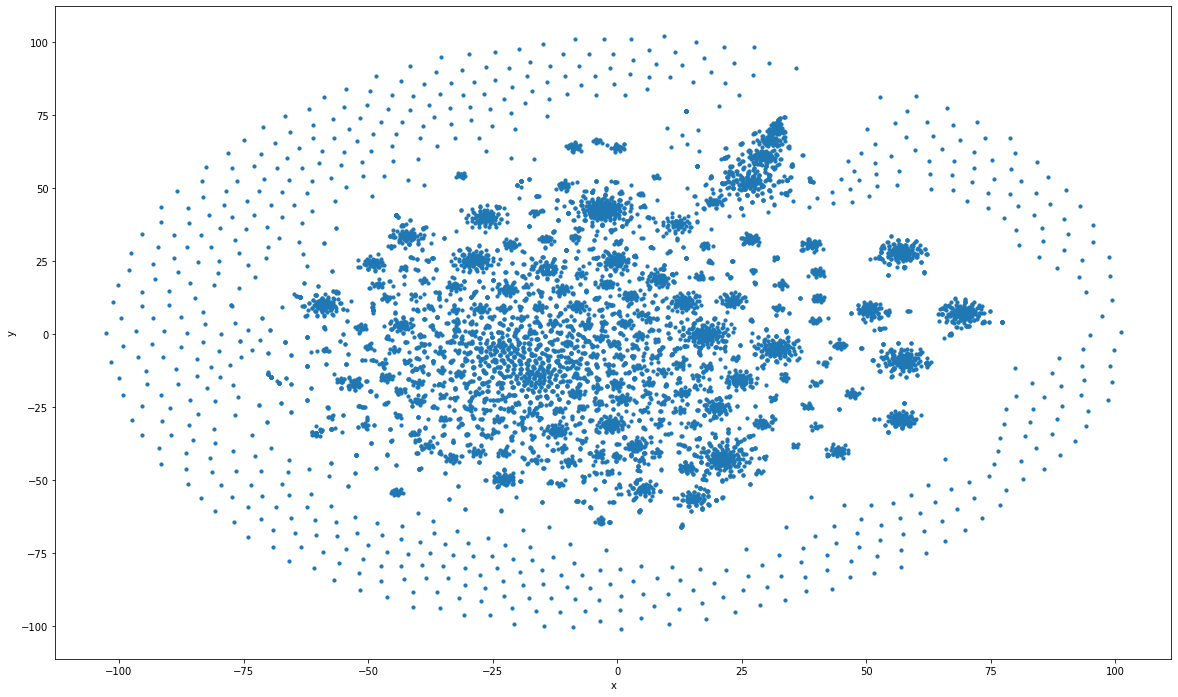

In [57]:
pointsspacy = pd.DataFrame(
    [(chat, coord[0], coord[1]) for (chat, coord) in zip(chats, matrix_dicc2d)],
    columns=["word", "x", "y"]
)
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

### Display clusters and clusters with biggest proportion of toxic words

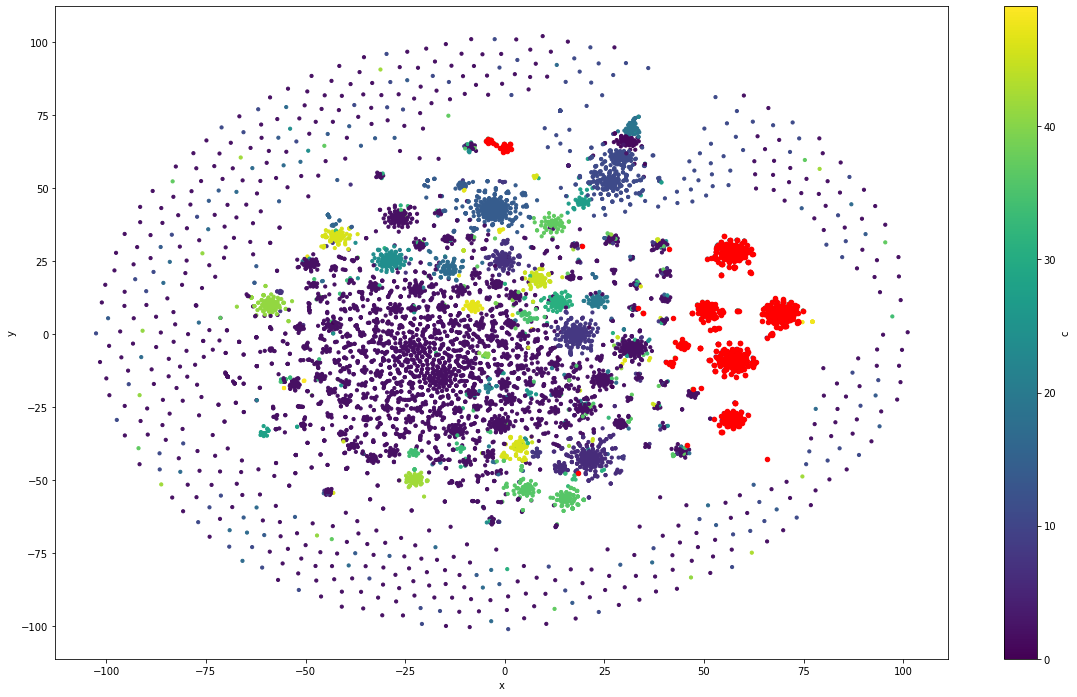

In [58]:
fig, ax = plt.subplots()
pointscluster = pd.DataFrame(
    [(chat, coord[0], coord[1], cluster) for (chat, coord, cluster) in zip(df_test['clean'], matrix_dicc2d, df_test['bow_clusters']) ],
    columns=["word", "x", "y", "c"]
)
pointscluster.plot(ax=ax, kind='scatter', x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))
toxic_clusters = pd.DataFrame(
    [(coord[0], coord[1]) for (coord, cluster) in zip(matrix_dicc2d, df_test['bow_clusters']) if cluster in top_toxic_clusters ],
    columns=["x", "y"]
)
toxic_clusters.plot(ax=ax, kind='scatter', x='x', y='y', color='red')
plt.show()